# Clustering Workflow & Analysis

In this notebook I execute the clustering on the given features, perform a first analysis on the results and relate it to various other resources.

In [2]:
import sys
sys.path.append("./notebooks")
sys.path.append("../src")

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from data_processing.geometry_processor import GeometryProcessor
from data_processing.feature_service import FeatureService
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from scipy.stats import gaussian_kde
from sklearn.cluster import KMeans, kmeans_plusplus

## Clustering Workflow

### Feature Generation

In [3]:
gp = GeometryProcessor()
band_data  = gp.flatten_and_filter_monthly_data()

fs = FeatureService(band_data)
feature_df = fs.calculate_features_for_monthly_data()

# feature_df.to_csv("features.csv")

scaler = MinMaxScaler()
feature_norm = scaler.fit_transform(feature_df) 

17:01:25.897517: [INFO] DATA_PROCESSING Initializing GeometryProcessor with data file: dataMonthly.npy

17:01:38.632224: [INFO] DATA_PROCESSING Initializing FeatureService

17:01:38.675913: [INFO] DATA_PROCESSING Calculating features with 5 feature definitions

17:01:49.363584: [INFO] DATA_PROCESSING Feature calculation completed. Generated 5 features



#### Features Used

The feature set includes five Sentinel-2 derived metrics:
- **Mean NDVI (last 12 months)**: Average chlorophyll content in recent period
- **Mean NDWI (last 12 months)**: Average water content in recent period  
- **NDWI Change**: Difference between recent 12 months (~2025) and first 12 months (~2020)
- **Temporal Variability (SAVI)**: Standard deviation of SAVI over the year
- **Spatial Variability Change**: Change in local NDVI heterogeneity (5×5 window)

### Data Visualization

To visualize the 5-dimensional feature space, I applied PCA to reduce it to three principal components for plotting (clustering is still performed on the original 5D space).

In [4]:
pca = PCA(n_components=3)
X_transformed = pca.fit_transform(feature_norm)

plot_data = X_transformed[::50].T
kde = gaussian_kde(plot_data)
density = kde(plot_data)

fig = go.Figure(data=[go.Scatter3d(
    x=X_transformed[::50, 0],
    y=X_transformed[::50, 1],
    z=X_transformed[::50, 2],
    mode='markers',
    marker=dict(
        size=4,
        color=density,
        colorscale='Viridis',
        opacity=0.8,
        colorbar=dict(title='Density')
    )
)])

fig.update_layout(
    title='PCA-Transformed and normalized Data',
    scene=dict(
        xaxis_title='PCA-Component 1',
        yaxis_title='PCA-Component 2',
        zaxis_title='PCA-Component 3'
    ),
    margin=dict(l=0, r=0, b=20, t=40),
    width=800,
    height=600
)

fig.show()

In [5]:
pca.components_

array([[ 4.7956005e-01,  5.9792095e-01,  4.8233843e-01,  2.5355092e-01,
        -3.3996215e-01],
       [-3.2668200e-01,  6.3718319e-02,  6.0020166e-04,  8.8881880e-01,
         3.1499150e-01],
       [-3.5605486e-02,  3.1330982e-01,  3.8410589e-01, -3.2146084e-01,
         8.0603647e-01]], dtype=float32)

##### Feature Space Analysis

As seen in the 3D PCA visualization, the data forms one continuous, elongated blob rather than distinct, separated clusters. This is expected: forest health exists on a continuum from healthy to severely degraded, with every intermediate state represented. The features (NDVI temporal patterns, spatial heterogeneity) naturally capture this gradual variation.

This continuous distribution creates a constraint for clustering algorithm selection. Density-based methods like DBSCAN and OPTICS rely on low-density regions separating clusters—which don't exist here. Hierarchical methods like Agglomerative Clustering are computationally infeasible for this dataset (~660k instances would require a full distance matrix exceeding available memory).

**This leaves K-Means as the most practical choice**: it partitions based on centroid distances rather than density separation, and scales well to large datasets. The trade-off is that K-Means will impose discrete boundaries on inherently continuous data, an acceptable compromise when the goal is to segment the landscape into interpretable health categories.

The PCA variance distribution also confirms that no single feature dominates. The variation is spread across multiple dimensions, suggesting all five features contribute meaningful information.

### Clustering Hyperparameters

In [6]:
sse = []

for i in range(1, 10):
    centroids, _ = kmeans_plusplus(feature_norm, n_clusters=i)
    kmeans = KMeans(n_clusters=i, random_state=10, init=centroids)

    labels = kmeans.fit_predict(feature_norm)
    
    sse.append(kmeans.inertia_)

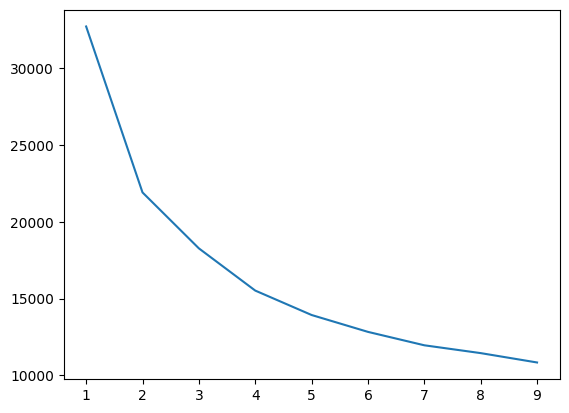

In [7]:
fig, ax = plt.subplots()

ax.plot(range(1, 10), sse)

#### Choosing k=4

The elbow plot shows no sharp elbow, which is related to the continuous nature of the data. However, two subtle inflection points are visible at $k=2$ and $k=4$.

While $k=2$ would provide a basic healthy/degraded binary split, $k=4$ offers finer granularity that better captures the spectrum of forest conditions without over-segmenting into too many categories.  
Four clusters allow for interpretable distinctions (e.g., healthy, early stress, moderate degradation, severe degradation) while remaining manageable for analysis and visualization.

### Clustering Execution

In [8]:
n_clusters = 4
centroids, _ = kmeans_plusplus(feature_norm, n_clusters=n_clusters, random_state=20)
kmeans = KMeans(n_clusters=n_clusters, random_state=20, init=centroids)

labels = kmeans.fit_predict(feature_norm)

labels_2d = gp.reconstruct_2d(labels)
gp.export_reconstruction_as_geotiff(labels, "labels.tif")

17:02:05.707726: [INFO] DATA_PROCESSING GeoTIFF exported to: labels.tif



## Clustering Result Analysis

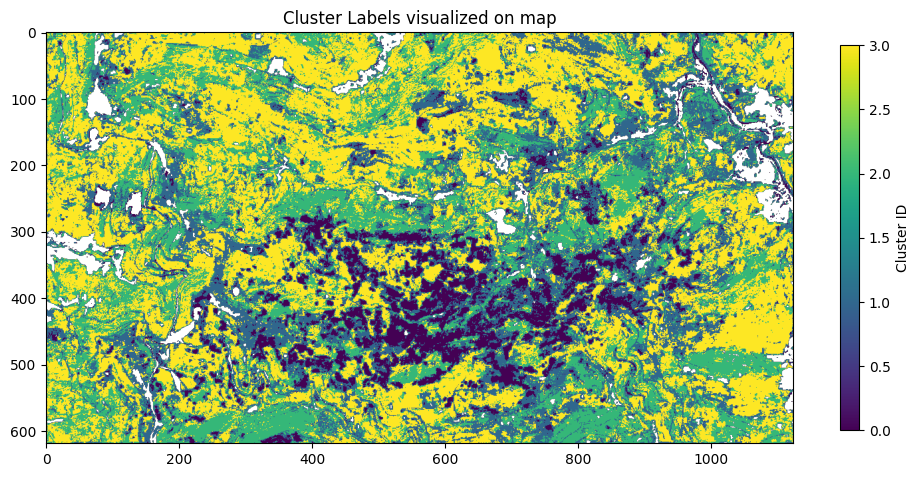

In [9]:
fig, ax = plt.subplots(figsize=(10, 8))

im = ax.imshow(labels_2d, cmap='viridis')
ax.set_title('Cluster Labels visualized on map')

cbar = fig.colorbar(im, ax=ax, shrink=0.5)
cbar.set_label("Cluster ID")

plt.tight_layout()

#### Spatial Distribution of Clusters

The clustering reveals clear spatial structure rather than random noise, suggesting the algorithm has captured meaningful patterns in forest health.

**Cluster 0** (dark purple) dominates the central region, forming large contiguous patches. This spatial coherence suggests it represents a distinct forest condition rather than scattered anomalies.

**Cluster 1** (teal/blue) predominantly appears at the boundaries of Cluster 0 patches, forming a transition zone. This spatial arrangement suggests Cluster 1 may represent an intermediate stress state or edge effects between healthy and degraded areas.

**Clusters 2 and 3** (green and yellow) are more spatially mixed and distributed across the landscape.

This spatial organization, particularly the clear core (Cluster 0) surrounded by transition zones (Cluster 1), will be evaluated further down below, when we look at other sources.

In [10]:
fig = go.Figure(data=[go.Scatter3d(
    x=X_transformed[::50, 0],
    y=X_transformed[::50, 1],
    z=X_transformed[::50, 2],
    mode='markers',
    marker=dict(
        size=4,
        color=labels[::50],
        colorscale='Viridis',
        opacity=0.8,
        colorbar=dict(title='Cluster Label')
    )
)])

fig.update_layout(
    title='3D Cluster Scatter Plot',
    scene=dict(
        xaxis_title='PCA-Component 1',
        yaxis_title='PCA-Component 2',
        zaxis_title='PCA-Component 3'
    ),
    margin=dict(l=0, r=0, b=20, t=40),
    width=800,
    height=600
)

fig.show()

#### Cluster Structure in Feature Space

The 3D PCA visualization shows how K-Means partitioned the continuous blob:

**Cluster 0** (dark purple) occupies one extreme of the elongated distribution, forming a distinct endpoint in feature space. Its separation from the main mass suggests it represents the most divergent forest condition in the dataset.

**Cluster 1** (teal) acts as an intermediate region, positioned between Cluster 0 and the remaining clusters. This placement in feature space reinforces the spatial observation that Cluster 1 forms transition zones, as it literally is *between* the extreme condition (Cluster 0) and the more typical conditions (Clusters 2 and 3).

**Clusters 2 and 3** (green and yellow) occupy the bulk of the distribution, splitting the remaining feature space.

This structure supports the hypothesis that the clusters capture a gradient from a distinct degraded state (Cluster 0) through transitional stress (Cluster 1) to more typical forest conditions (Clusters 2 and 3).

### Cluster-Centroids

In [11]:
cluster_centers = kmeans.cluster_centers_
feature_names = feature_df.columns

centers_original = scaler.inverse_transform(cluster_centers)

centers_df = pd.DataFrame(
    centers_original,
    columns=feature_names,
    index=[f'Cluster {i}' for i in range(4)]
)

print("Cluster Centers (Original Feature Scale):")
print(centers_df.round(3))

Cluster Centers (Original Feature Scale):
            mean  mean2  difference_in_mean_between_intervals    std  \
Cluster 0  0.549  0.163                                -0.123  0.137   
Cluster 1  0.661  0.317                                 0.076  0.158   
Cluster 2  0.740  0.456                                 0.144  0.199   
Cluster 3  0.775  0.433                                 0.133  0.151   

           spatial_std_difference  
Cluster 0                   0.071  
Cluster 1                   0.046  
Cluster 2                   0.035  
Cluster 3                   0.025  


### Feature Ranges per Cluster

In [12]:
result_df = feature_df.copy()
result_df["cluster"] = labels

y_cols = [
    "mean",
    "mean2",
    "difference_in_mean_between_intervals",
    "std",
    "spatial_std_difference",
]

titles = {
    "mean": "Mean NDVI (Last 12 Months)",
    "mean2": "Mean NDWI (Last 12 Months)",
    "difference_in_mean_between_intervals": "NDWI Change: Recent 12 Months vs First 12 Months",
    "std": "Temporal Variability of SAVI",
    "spatial_std_difference": "Change in Local NDVI Spatial Variability (5×5 Window)"
}

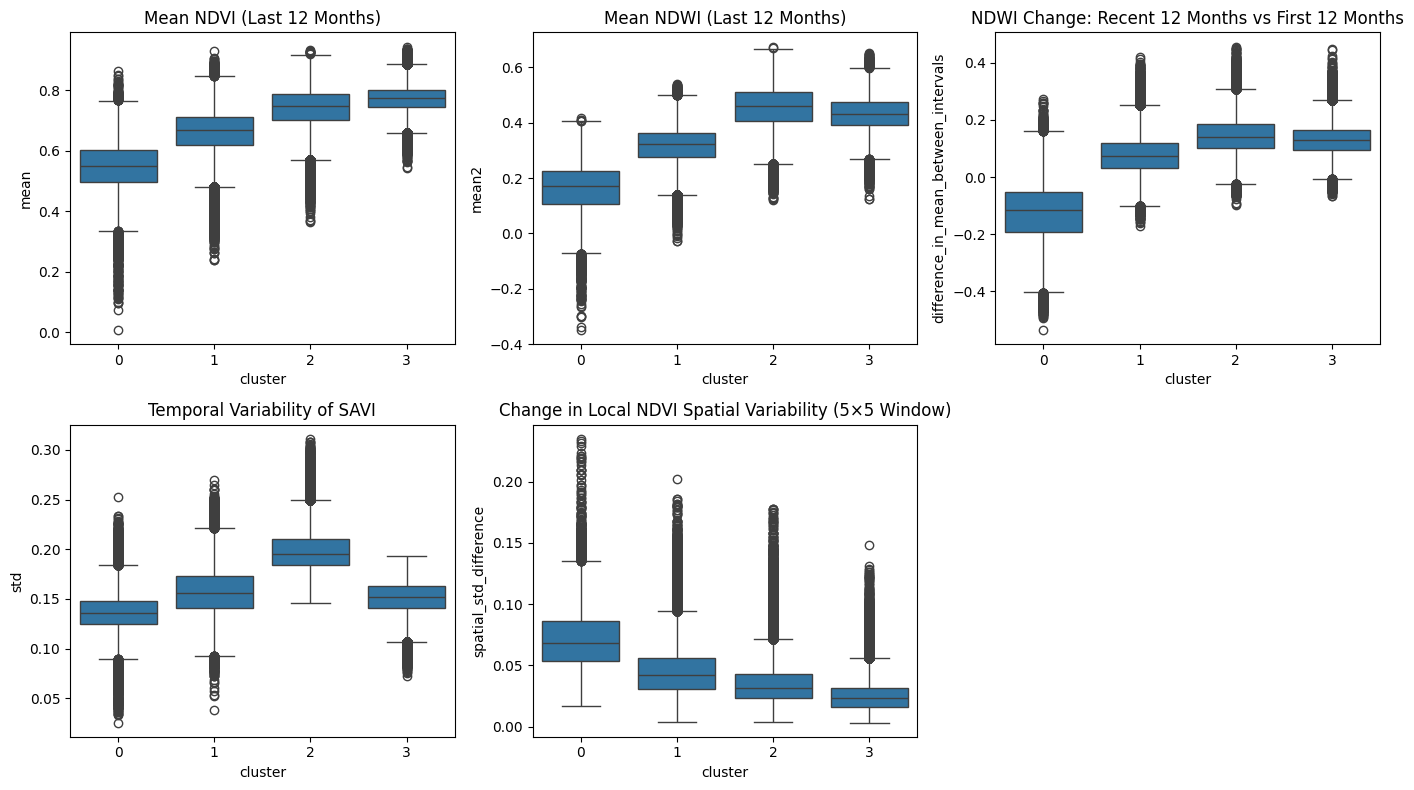

In [18]:
fig, axes = plt.subplots(2, 3, figsize=(14, 8))

for ax, col in zip(axes.flatten(), y_cols):
    sns.boxplot(data=result_df, x="cluster", y=col, ax=ax)
    ax.set_title(titles[col])

axes[1, 2].set_axis_off()

plt.tight_layout()
plt.show()

#### Cluster Interpretation

The feature distributions reveal distinct forest conditions for each cluster:

##### Cluster 0: Severe Degradation
- **Low mean NDVI and NDWI**: Indicates reduced chlorophyll and water content -> hallmarks of dead or dying vegetation
- **Negative NDWI change**: Water content has declined over the five-year period, showing progressive deterioration
- **Low temporal variability (SAVI)**: Dead or severely stressed trees exhibit minimal seasonal variation, unlike healthy vegetation with annual growth cycles
- **High spatial variability**: Suggests a patchy degradation pattern -> some remaining vegetation interspersed with dead areas, rather than uniform bare ground. This is confirmed in the RGB imagery below, where Cluster 0 areas show scattered surviving trees rather than complete deforestation.

This cluster represents the most severely degraded forest areas.

##### Cluster 1: Transition/Moderate Stress
All features fall consistently between Cluster 0 and Clusters 2/3. This intermediate positioning across nearly every metric strongly supports the hypothesis that Cluster 1 represents areas under stress or partial mortality, a transitional state between healthy forest and severe degradation.

##### Clusters 2 & 3: Healthy Forest with Compositional Differences
Both clusters show high NDVI/NDWI and positive or stable trends, indicating healthy vegetation. The key distinction:

- **Cluster 2**: Higher temporal variability (SAVI) and broader NDVI/NDWI spread
- **Cluster 3**: Lower temporal variability and tighter distributions

**Hypothesis**: The difference in temporal variability could reflect forest composition. Cluster 2 potentially representing deciduous-dominated or mixed forest with pronounced seasonal cycles, while Cluster 3 represents evergreen-dominated forest with more stable year-round canopy. This would require validation with forest inventory or land cover data.

##### Summary
The clusters capture a gradient from severe degradation (0) through transitional stress (1) to healthy forest, with Clusters 2 and 3 distinguishing different healthy forest types, likely based on composition and phenology.

<img src="../DATA/images/rgb.png" alt="RGB" width="60%">

### Other sources and their classification

<img src="../DATA/images/result.png" alt="Result" width="60%">  

**My clustering results** (Cluster 0 = dark purple degraded areas, Cluster 1 = teal transition zone)  
Source: this notebook  

---
<img src="../DATA/images/deadtrees.png" alt="DeadTrees" width="60%">  

**Standing dead trees** (orange = high mortality, green = low mortality)  
Based on Sentinel-2 imagery and ML classification  
Source: https://deadtrees.earth/deadtrees (accessed 16.02.2026)

---
<img src="../DATA/images/waldmonitor.png" alt="Waldmonitor" width="60%">  

**Vegetation degradation by detection period** (cyan/white = recent 2022-2024, purple = older 2017-2020)  
Based on NDVI difference thresholds  
Source: https://map3d.remote-sensing-solutions.de/waldmonitor-deutschland/ (accessed 16.02.2026)

#### Validation Against External Sources

To validate the clustering results, I compared them against two external forest monitoring tools:

**Waldmonitor** uses NDVI difference thresholds relative to previous years to detect vegetation loss. The color-coded overlay shows degradation detected in different time periods (2017-2024), with the temporal progression reflecting when damage was first detected.

**deadtrees.earth** employs a machine learning model trained on manually labeled aerial imagery to estimate the percentage of standing dead trees per pixel. This approach provides more nuanced estimates than simple threshold-based methods.

##### Comparison Results

The clustering successfully identifies the main degradation zone:

- **Cluster 0** (dark purple in my results) aligns closely with the central degraded area visible in both Waldmonitor and deadtrees.earth. The spatial extent and location match the regions showing highest mortality (orange pixels in deadtrees.earth, cyan/white in Waldmonitor's 2022-2024 layer).

- **Cluster 1** (teal) corresponds to areas with lower percentages of standing dead trees in the deadtrees.earth map, supporting the interpretation that this cluster represents transitional stress or partial mortality rather than complete forest loss.

- **Clusters 2 and 3** align with areas showing little to no detected damage in both external sources, consistent with the healthy forest interpretation.

The strong spatial agreement between my unsupervised clustering approach and two independent methods, one threshold-based (Waldmonitor), one ML-supervised (deadtrees.earth), validates that the clusters capture real forest health patterns rather than algorithmic artifacts.

**Remaining hypothesis**: The compositional difference between Clusters 2 and 3 (deciduous vs. evergreen) cannot be verified with these data sources and requires forest inventory or land cover validation.

## Conclusion and Next Steps

This clustering analysis successfully identified distinct forest health states across the study area using unsupervised learning on multi-temporal Sentinel-2 features. The results align well with two independent validation sources, Waldmonitor's threshold-based approach and deadtrees.earth's supervised ML classification, confirming that the clusters capture real patterns of forest degradation rather than algorithmic artifacts.

### Key Findings

The four-cluster solution revealed:
- **Severe degradation** (Cluster 0): Low NDVI/NDWI, declining water content, and patchy mortality patterns in the central region
- **Transitional stress** (Cluster 1): Intermediate values across all metrics, forming spatial buffers around degraded areas
- **Healthy forest variants** (Clusters 2 & 3): High vegetation indices with differing temporal dynamics, potentially reflecting compositional differences

### Limitations and Open Questions

While the clustering effectively segments forest health states, several questions remain:
- What drives the spatial distribution of degradation? Why is the central region most affected?
- Do topographic factors (elevation, slope, aspect) correlate with cluster membership?
- Can Clusters 2 and 3 be linked to specific forest types (deciduous vs. evergreen)?

### Moving Forward

The next analysis (`notebooks/dem_analysis.ipynb`) will:
1. Extract elevation, slope, and aspect for each pixel
2. Analyze topographic distributions within each cluster
3. Test whether degradation (Cluster 0) correlates with specific landscape positions